# Homework 2 - T. Bruyelle

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import exponential
import statsmodels
import scipy.stats

## Problem 3 

$longest\_path\_length$ is a function such that : 
$$(z_{1}, \ldots, z_{6}) \mapsto max(z_1 + z_2 + z_4, z_1 + z_3, z_5 + z_6)$$

This function is used to sample the rv $L$ since we want to estimate $\mathbb{E}(L)$.

### i - Monte Carlo Standard

Here our estimator is : 
$$\alpha^{(n)}_{MC} = \frac{1}{n} \displaystyle \sum_{i=0}^{n-1}L_{i}$$


where $(L_0, \ldots, L_{n-1})$ are $iid$ observations of $L$. 

In [3]:
n = 1000
lambda_1 = 1
lambda_2 = 1 / 2
lambda_3 = 1 / 3
lambda_4 = 1 / 4
lambda_5 = 1 / 15
lambda_6 = 1 / 6

def longest_path_length(z1, z2, z3, z4, z5, z6):
    return max(z1 + z2 + z4, z1 + z3, z5 + z6)

def inverse_cdf_exponential_law(x,mean) :
    return mean * np.log(1 / (1-x))

## Simulations
Z1 = exponential(1/lambda_1,n)
Z2 = exponential(1/lambda_2,n)
Z3 = exponential(1/lambda_3,n)
Z4 = exponential(1/lambda_4,n)
Z5 = exponential(1/lambda_5,n)
Z6 = exponential(1/lambda_6,n)

L = []
for i in range(n) :
    L.append(longest_path_length(Z1[i],Z2[i],Z3[i],Z4[i],Z5[i],Z6[i]))
L = np.array(L)

# 1 - MC Standard
print("MC (standard) estimator : ", np.mean(L))
print("MC (standard) estimated variance : ", (1/n) * np.var(L))

MC (standard) estimator :  23.32245433667161
MC (standard) estimated variance :  0.2820056962961351


### ii -  Monte-Carlo with Control Variate

Let us consider the control variate : 
$$ C = (Z_{1}, \ldots, Z_{6})^{T}$$


With this setting we would like to estimate $\mathbb{E}(X)$ where : 
$$X(\lambda) := L - \lambda^{T}(C - \mathbb{E}(C))$$


In order to have the smallest variance, I took :
$$\lambda^{*} = \Sigma^{-1}   \left[ {\begin{array}{cc}
   cov(L, Z_1 - \mathbb{E}(Z_1) ) \\
   \vdots \\
   cov(L, Z_2 - \mathbb{E}(Z_2) )\\
  \end{array} } \right] $$


In [4]:
C = np.array([Z1 - np.mean(Z1),Z2 - np.mean(Z2), Z3 - np.mean(Z3),
              Z4 - np.mean(Z4),Z5 - np.mean(Z5), Z6 - np.mean(Z6)])

cov_vec = np.array([np.cov(L,C[0,])[0,1],np.cov(L,C[1,])[0,1],np.cov(L,C[2,])[0,1],
                    np.cov(L,C[3,])[0,1],np.cov(L,C[4,])[0,1],np.cov(L,C[5,])[0,1]])
Sigma = np.cov([C[0,],C[1,],C[2,],C[3,],C[4,],C[5,]])
lambda_star = np.dot(np.linalg.inv(Sigma), cov_vec)

L_var_red = L - np.dot(lambda_star, C)
print("MC (control variate) estimator : ", np.mean(L_var_red))
print("MC (control variate) estimated variance : ", (1/n) * np.var(L_var_red))

# (1-alpha) % confidence interval.
alpha = 0.1
z = scipy.stats.norm.ppf(1-alpha/2)
inf = np.mean(L_var_red) - (z/np.sqrt(n)) * np.var(L_var_red)
sup = np.mean(L_var_red) + (z/np.sqrt(n)) * np.var(L_var_red)
print("({})% confidence interval : ".format((1-alpha)*100),"[",inf,",", sup, "]")

MC (control variate) estimator :  23.32245433667161
MC (control variate) estimated variance :  0.004543180747351279
(90.0)% confidence interval :  [ 23.086141522515405 , 23.558767150827812 ]


### iii - Antithetic Variate

As $F_{X}^{-1}(U) \sim X$ when $U \sim \mathcal{U}([0,1])$, we can simulate an exponential law since its cumulative 
distribution function is easily invertible.

Since $U \sim 1-U$, we can compute the Antithetic Variate Estimator : 
$$\alpha_{AV}^{(n)} = \frac{1}{2n} \displaystyle \sum_{i=0}^{n-1} \phi(U_{i}) + \phi(1-U_{i})$$

where $\phi : u \mapsto \max(F_{\mathcal{E}(1)}^{-1}(u)+F_{\mathcal{E}(2)}^{-1}(u)+F_{\mathcal{E}(4)}^{-1}(u),F_{\mathcal{E}(1)}^{-1}(u) +
F_{\mathcal{E}(3)}^{-1}(u),F_{\mathcal{E}(5)}^{-1}(u) + F_{\mathcal{E}(6)}^{-1}(u))$


In [5]:
U = np.random.uniform(0,1,n)

Z1_bis = [] ; Z1_bis_trans = []
Z2_bis = [] ; Z2_bis_trans = []
Z3_bis = [] ; Z3_bis_trans = []
Z4_bis = [] ; Z4_bis_trans = []
Z5_bis = [] ; Z5_bis_trans = []
Z6_bis = [] ; Z6_bis_trans = []

for i in range(n) : 
    Z1_bis.append(inverse_cdf_exponential_law(U[i], 1 / lambda_1))
    Z2_bis.append(inverse_cdf_exponential_law(U[i], 1 / lambda_2))
    Z3_bis.append(inverse_cdf_exponential_law(U[i], 1 / lambda_3))
    Z4_bis.append(inverse_cdf_exponential_law(U[i], 1 / lambda_4))
    Z5_bis.append(inverse_cdf_exponential_law(U[i], 1 / lambda_5))
    Z6_bis.append(inverse_cdf_exponential_law(U[i], 1 / lambda_6))
    # antithetic tranformation of the sample U
    Z1_bis_trans.append(inverse_cdf_exponential_law(1-U[i], 1 / lambda_1))
    Z2_bis_trans.append(inverse_cdf_exponential_law(1-U[i], 1 / lambda_2))
    Z3_bis_trans.append(inverse_cdf_exponential_law(1-U[i], 1 / lambda_3))
    Z4_bis_trans.append(inverse_cdf_exponential_law(1-U[i], 1 / lambda_4))
    Z5_bis_trans.append(inverse_cdf_exponential_law(1-U[i], 1 / lambda_5))
    Z6_bis_trans.append(inverse_cdf_exponential_law(1-U[i], 1 / lambda_6))

L_anti = []
L_anti_trans = []
for i in range(n) :
    L_anti.append(longest_path_length(Z1_bis[i],Z2_bis[i],Z3_bis[i],
                                      Z4_bis[i],Z5_bis[i],Z6_bis[i]))
    L_anti_trans.append(longest_path_length(Z1_bis_trans[i], Z2_bis_trans[i],
                                            Z3_bis_trans[i], Z4_bis_trans[i],
                                            Z5_bis_trans[i], Z6_bis_trans[i]))
L_anti = np.array(L_anti)
L_anti_trans = np.array(L_anti_trans)

print("MC (antithetic variate) estimator : ",
      0.5 * np.mean(L_anti + L_anti_trans))
print("MC (antithetic variate) estimated variance : ",
      (0.25 / n) * np.var(L_anti + L_anti_trans))

# (1-alpha) % confidence interval.
alpha = 0.1
z = scipy.stats.norm.ppf(1-alpha/2)
inf = 0.5 * np.mean(L_anti + L_anti_trans) - (z/np.sqrt(n)) * np.var(L_var_red)
sup = 0.5 * np.mean(L_anti + L_anti_trans) + (z/np.sqrt(n)) * np.var(L_var_red)
print("({})% confidence interval : ".format((1-alpha)*100),"[",inf,",", sup, "]")



MC (antithetic variate) estimator :  21.08194519005598
MC (antithetic variate) estimated variance :  0.0822258641377058
(90.0)% confidence interval :  [ 20.845632375899775 , 21.318258004212183 ]



## Problem 4

Let us write : 
$$A := \{(x,y) \in \mathbb{R}^{2} | x \geq 3 \quad and  \quad y \geq 3 \}$$.


We want to compute : 
$$p := \mathbb{P}((X,Y) \in A) = \mathbb{E}(\mathbb{1}_{\{(X,Y) \in A\}})$$.


Consequently, we can define the Monte Carlo standard estimator : 
$$p_{n} := \frac{1}{n} \displaystyle \sum_{i=0}^{n-1} \mathbb{1}_{\{(x_{i},y_{i}) \in A\}}. $$



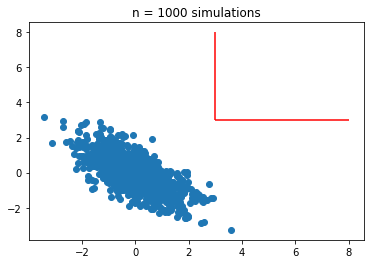

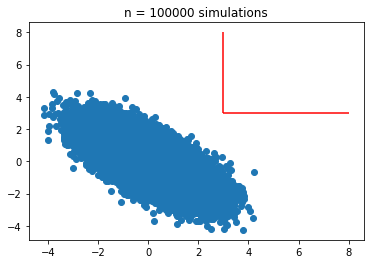

In [ ]:
mean = np.array([0,0])
cov = np.array([[1,-0.7],[-0.7,1]])
# Simulations
for n in [1000, 100000, 100000000] : 
    X_Y = np.random.multivariate_normal(mean, cov, size=n)
    # np.cov(X_Y[:,0], X_Y[:,1])
    # Plots
    plt.scatter(x=X_Y[:,0], y=X_Y[:,1])
    plt.vlines(3, ymin=3, ymax = 8, color = "red", linestyles='solid')
    plt.hlines(3, xmin=3, xmax = 8, color = "red")
    plt.title("n = {} simulations".format(n))
    plt.show()

In each case we have $p_{n} = 0 $ so we cannot compute any confidence interval. In order to use importance sampling, let
us consider $g$ the pdf of $\mathcal{N}(   
  \left[ {\begin{array}{cc}
   3 \\
   3\\
  \end{array} } \right], 
  \left[ {\begin{array}{cc}
   1 & -0.7 \\
   -0.7 & 1 \\
  \end{array} } \right]
)$ so we compute : 
$$\mathbb{E}_{g}(\mathbb{1}(Z \in A) \frac{f(Z)}{g(Z)})$$


where $Z = (X,Y)$ and $f$ is the pdf of $\mathcal{N}(   
  \left[ {\begin{array}{cc}
   0 \\
   0\\
  \end{array} } \right], 
  \left[ {\begin{array}{cc}
   1 & -0.7 \\
   -0.7 & 1 \\
  \end{array} } \right]
)$. 



In [ ]:
# Importance Sampling
n = 100000
mean_2 = np.array([3,3])
Z = np.random.multivariate_normal(mean_2, cov, size=n)
f = scipy.stats.multivariate_normal(mean=[0,0], cov=[[1,-0.7],[-0.7,1]])
g = scipy.stats.multivariate_normal(mean=[3,3], cov=[[1,-0.7],[-0.7,1]])

# Plots 
plt.scatter(x=Z[:,0], y=Z[:,1])
plt.vlines(3, ymin=3, ymax = 8, color = "red", linestyles='solid')
plt.hlines(3, xmin=3, xmax = 8, color = "red")
plt.title("n = {} simulations".format(n))
plt.show()

ratio = [] # only if Z belongs to A
for i in range(n) :
    if Z[i][0] >= 3 and Z[i][1] > 3 :
        ratio.append(f.pdf(Z[i]) / g.pdf(Z[i]))
ratio = np.array(ratio)



In [ ]:
print("{} simulations".format(n))
print("p_n = ", np.mean(ratio))
print("Estimated variance of the estimator : ", (1/n) * np.var(ratio))

# (1-alpha) % confidence interval.
alpha = 0.1
z = scipy.stats.norm.ppf(1-alpha/2)
inf = np.mean(ratio) - (z/np.sqrt(n)) * np.var(ratio)
sup = np.mean(ratio) + (z/np.sqrt(n)) * np.var(ratio)
print("({})% confidence interval : ".format((1-alpha)*100),"[",inf,",", sup, "]")